In [3]:
from skimage import io
from skimage.util import img_as_ubyte
import matplotlib.pyplot as plt
import numpy as np
import glob
from sklearn.decomposition import PCA
from skimage.transform import SimilarityTransform
from skimage.transform import warp
import os
import pathlib

In [4]:
def read_landmark_file(file_name):
    f = open(file_name, 'r')
    lm_s = f.readline().strip().split(' ')
    n_lms = int(lm_s[0])
    if n_lms < 3:
        print(f"Not enough landmarks found")
        return None

    new_lms = 3
    # 3 landmarks each with (x,y)
    lm = np.zeros((new_lms, 2))
    for i in range(new_lms):
        lm[i, 0] = lm_s[1 + i * 2]
        lm[i, 1] = lm_s[2 + i * 2]
    return lm

In [5]:
def align_and_crop_one_cat_to_destination_cat(img_src, lm_src, img_dst, lm_dst):
    """
    Landmark based alignment of one cat image to a destination
    :param img_src: Image of source cat
    :param lm_src: Landmarks for source cat
    :param lm_dst: Landmarks for destination cat
    :return: Warped and cropped source image. None if something did not work
    """
    tform = SimilarityTransform()
    tform.estimate(lm_src, lm_dst)
    warped = warp(img_src, tform.inverse, output_shape=img_dst.shape)

    # Center of crop region
    cy = 185
    cx = 210
    # half the size of the crop box
    sz = 180
    warp_crop = warped[cy - sz:cy + sz, cx - sz:cx + sz]
    shape = warp_crop.shape
    if shape[0] == sz * 2 and shape[1] == sz * 2:
        return img_as_ubyte(warp_crop)
    else:
        print(f"Could not crop image. It has shape {shape}. Probably to close to border of image")
        return None

In [6]:
def preprocess_all_cats(in_dir, out_dir):
    """
    Create aligned and cropped version of image
    :param in_dir: Where are the original photos and landmark files
    :param out_dir: Where should the preprocessed files be placed
    """
    dst = "data/ModelCat"
    dst_lm = read_landmark_file(f"{dst}.jpg.cat")
    dst_img = io.imread(f"{dst}.jpg")

    all_images = glob.glob(in_dir + "*.jpg")
    for img_idx in all_images:
        name_no_ext = os.path.splitext(img_idx)[0]
        base_name = os.path.basename(name_no_ext)
        out_name = f"{out_dir}/{base_name}_preprocessed.jpg"

        src_lm = read_landmark_file(f"{name_no_ext}.jpg.cat")
        src_img = io.imread(f"{name_no_ext}.jpg")

        proc_img = align_and_crop_one_cat_to_destination_cat(src_img, src_lm, dst_img, dst_lm)
        if proc_img is not None:
            io.imsave(out_name, proc_img)

In [7]:
def preprocess_one_cat():
    src = "data/MissingCat"
    dst = "data/ModelCat"
    out = "data/MissingCatProcessed.jpg"

    src_lm = read_landmark_file(f"{src}.jpg.cat")
    dst_lm = read_landmark_file(f"{dst}.jpg.cat")

    src_img = io.imread(f"{src}.jpg")
    dst_img = io.imread(f"{dst}.jpg")

    src_proc = align_and_crop_one_cat_to_destination_cat(src_img, src_lm, dst_img, dst_lm)
    if src_proc is None:
        return

    io.imsave(out, src_proc)

    fig, ax = plt.subplots(ncols=3, figsize=(16, 6))
    ax[0].imshow(src_img)
    ax[0].plot(src_lm[:, 0], src_lm[:, 1], '.r', markersize=12)
    ax[1].imshow(dst_img)
    ax[1].plot(dst_lm[:, 0], dst_lm[:, 1], '.r', markersize=12)
    ax[2].imshow(src_proc)
    for a in ax:
        a.axis('off')
    plt.tight_layout()
    plt.show()

In [8]:
def create_u_byte_image_from_vector(im_vec, height, width, channels):
    min_val = im_vec.min()
    max_val = im_vec.max()

    # Transform to [0, 1]
    im_vec = np.subtract(im_vec, min_val)
    im_vec = np.divide(im_vec, max_val - min_val)
    im_vec = im_vec.reshape(height, width, channels)
    im_out = img_as_ubyte(im_vec)
    return im_out

## Exercise 1

In [12]:
preprocess_all_cats("training_data_100/", "training_data_100_preprocessed/")

## Exercise 2

In [17]:
preprocessed_images = glob.glob("training_data_100_preprocessed/*.jpg")
n_preprocessed_img = len(preprocessed_images)
#read first image to get size
img = io.imread(f"training_data_100_preprocessed/00000001_000_preprocessed.jpg")
height, width, channels = img.shape
n_samples = n_preprocessed_img
n_features = height * width * channels
data_matrix = np.zeros((n_samples, n_features))
i = 0
for img_idx in preprocessed_images:
    img = io.imread(img_idx)
    flat_img = img.flatten()
    data_matrix[i,:] = flat_img
    i += 1

print(f"Data matrix shape: {data_matrix.shape}")
print(f"Data matrix: {data_matrix}")

Data matrix shape: (100, 388800)
Data matrix: [[114.  88.  75. ...  28.  24.  23.]
 [  0.   0.   0. ...  64.  50.  49.]
 [ 62.  57.  54. ... 233. 233. 233.]
 ...
 [ 68.  73.  66. ...  43.  35.  32.]
 [207. 107.  58. ... 246. 244. 245.]
 [111.  93.  81. ...  24.  25.  20.]]


## Exercise 3

In [21]:
# compute average
average_face = np.mean(data_matrix, axis=0)
print(f"Average face shape: {average_face.shape}")
print(f"Average face: {average_face}")

Average face shape: (388800,)
Average face: [ 90.21  77.8   72.38 ... 103.25  95.79  89.52]


## Exercise 4

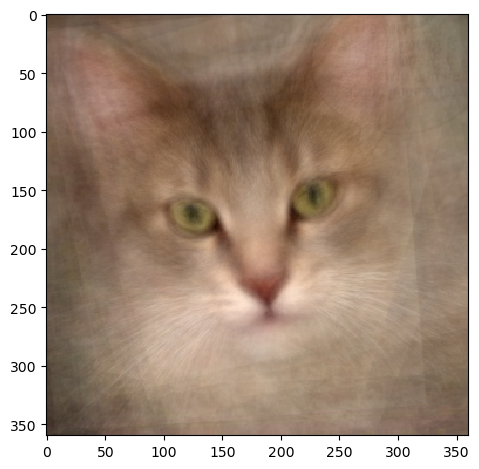

In [22]:
# Visualize average face
average_face_img = create_u_byte_image_from_vector(average_face, height, width, channels)
io.imshow(average_face_img)

## Exercise 6

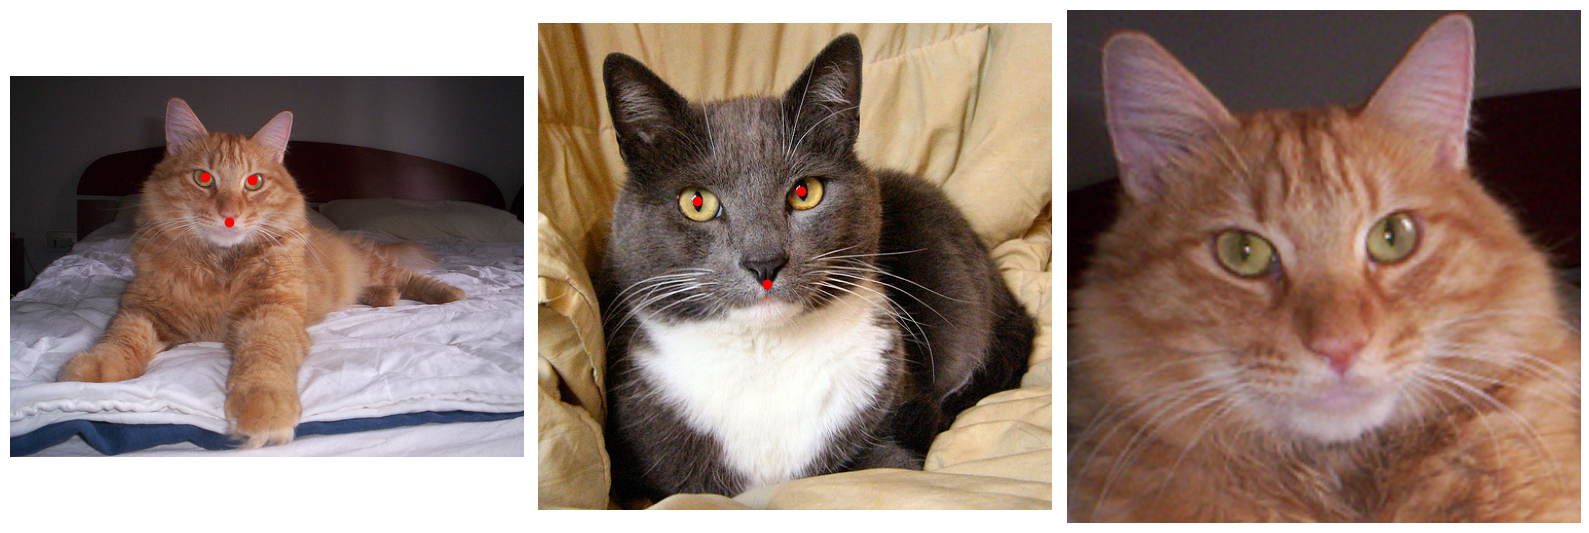

In [23]:
preprocess_one_cat()

## Exercise 7

In [25]:
missing_cat_img = io.imread(f"data/MissingCatProcessed.jpg")
height, width, channels = missing_cat_img.shape
print(f"Missing cat shape: {missing_cat_img.shape}")
flat_missing_cat_img = missing_cat_img.flatten()
print(f"Missing cat: {flat_missing_cat_img}")


Missing cat shape: (360, 360, 3)
Missing cat: [ 54  44  52 ... 202 159 117]


## Exercise 8

In [26]:
sub_data = data_matrix - flat_missing_cat_img
sub_distances = np.linalg.norm(sub_data, axis=1)
print(f"Sub distances: {sub_distances}")

Sub distances: [47281.68683539 41374.14074032 48887.3922704  56602.31496149
 53648.62755933 55735.10365111 47249.47984899 36823.89971201
 47193.93991817 67731.54073251 35932.39168216 53647.11831963
 41389.00962816 57355.9634563  44517.77602262 54524.06764907
 56404.66540101 42999.92936041 57124.4567589  45191.48756127
 55387.73921185 45338.97074262 40874.45109112 56817.41071186
 44662.1847428  53733.43595937 51523.35842121 45961.01058506
 38207.78857772 45610.40710189 37382.35892771 44349.09421848
 33047.79729422 66950.25090319 51988.35140683 42104.00015438
 40053.19414229 53890.76264073 53155.94851943 49089.1236528
 48103.44163363 42752.92083589 51811.11957872 53336.63432389
 50297.63856286 41108.64167058 50570.99101263 59513.64532609
 54124.36164982 37078.81918292 53098.94877491 48229.62840413
 43608.42976994 56392.60650121 49589.94639037 42342.31039988
 58234.3077232  54843.24641193 54794.18998398 50612.587545
 50991.22544125 61511.42682462 46653.90820714 47219.8996187
 51810.175834

## Exercise 9

In [27]:
closest_cat = np.argmin(sub_distances)
print(f"Closest cat: {closest_cat}")

Closest cat: 32


## Exercise 10

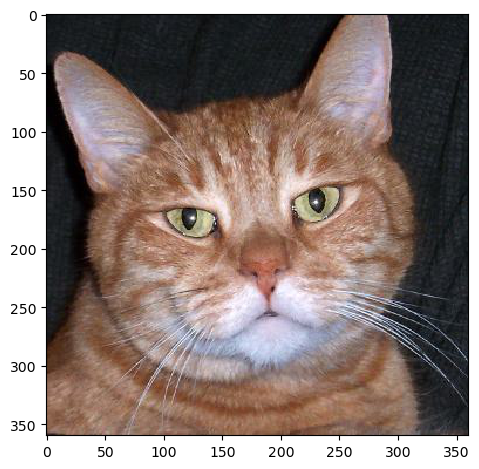

In [28]:
#Extract closest cat
closest_cat_img = io.imread(preprocessed_images[closest_cat])
closest_cat_img = create_u_byte_image_from_vector(closest_cat_img.flatten(), height, width, channels)
io.imshow(closest_cat_img)

## Exercise 11

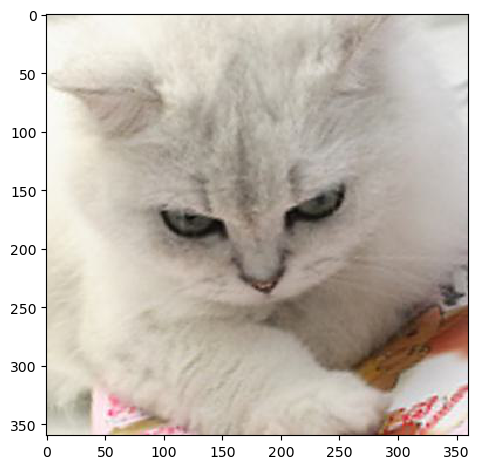

In [29]:
not_closest_cat = np.argmax(sub_distances)
not_closest_cat_img = io.imread(preprocessed_images[not_closest_cat])
not_closest_cat_img = create_u_byte_image_from_vector(not_closest_cat_img.flatten(), height, width, channels)
io.imshow(not_closest_cat_img)

## Exercise 12

In [30]:
print("Computing PCA")
cats_pca = PCA(n_components=50)
cats_pca.fit(data_matrix)

Computing PCA


PCA(n_components=50)

## Exercise 13

[0.26384545 0.10151527 0.09472695 0.05877889 0.03997328 0.03613464
 0.0308253  0.02569814 0.02072572 0.01835274 0.0173239  0.01600348
 0.01314888 0.01174989 0.01081358 0.00978463 0.00890881 0.00831116
 0.00782205 0.00739784 0.00706866 0.00692865 0.0066     0.00639824
 0.00598202 0.00552109 0.00526316 0.00497004 0.00482285 0.0046979
 0.00450056 0.0043224  0.00424856 0.00405017 0.00393896 0.00385884
 0.00370205 0.00356089 0.0034132  0.00335189 0.00323601 0.00307799
 0.00301318 0.00296946 0.00284796 0.0028103  0.00276407 0.00267615
 0.00256902 0.00251086]


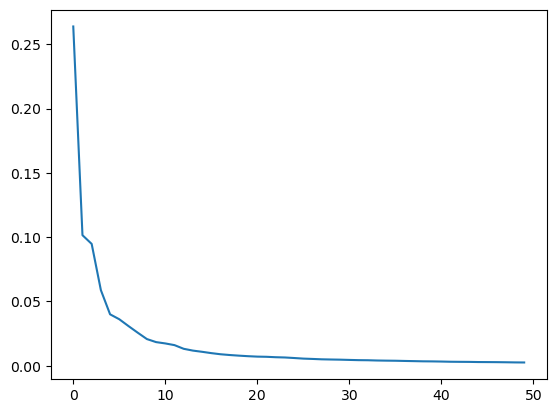

In [33]:
print(cats_pca.explained_variance_ratio_)
plt.plot(cats_pca.explained_variance_ratio_)

## Exercise 14

In [35]:
print(cats_pca.explained_variance_ratio_[0]*100,"%")

26.38454470771573 %


## Exercise 15

In [36]:
components = cats_pca.transform(data_matrix)

## Exercise 16

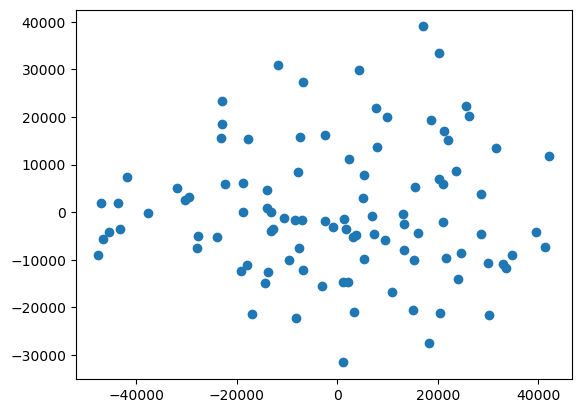

In [37]:
pc_1 = components[:, 0]
pc_2 = components[:, 1]
plt.scatter(pc_1, pc_2)

## Exercise 17

Min 1: 65
Max 1: 18
Min 2: 40
Max 2: 70


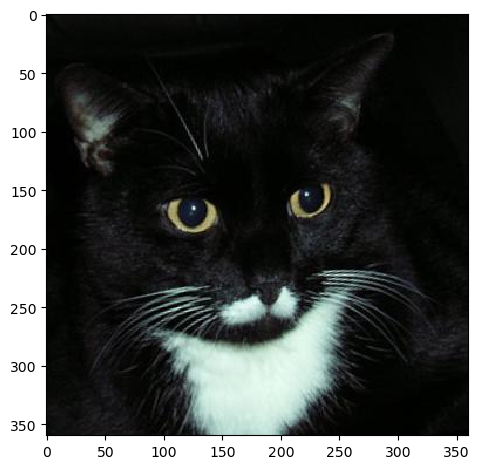

In [40]:
ext_min_1 = np.argmin(pc_1)
ext_max_1 = np.argmax(pc_1)
ext_min_2 = np.argmin(pc_2)
ext_max_2 = np.argmax(pc_2)
print(f"Min 1: {ext_min_1}")
print(f"Max 1: {ext_max_1}")
print(f"Min 2: {ext_min_2}")
print(f"Max 2: {ext_max_2}")

min_1_img = io.imread(preprocessed_images[ext_min_1])
min_1_img = create_u_byte_image_from_vector(min_1_img.flatten(), height, width, channels)
io.imshow(min_1_img)



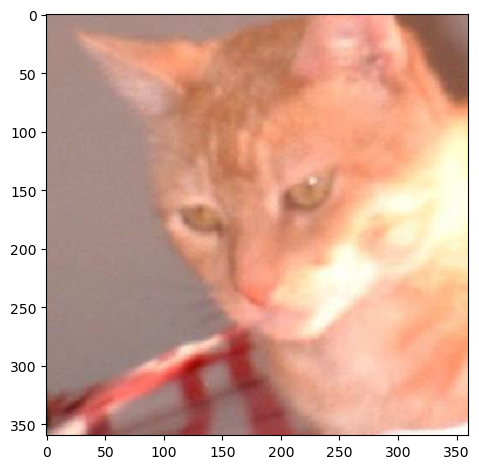

In [41]:
max_1_img = io.imread(preprocessed_images[ext_max_1])
max_1_img = create_u_byte_image_from_vector(max_1_img.flatten(), height, width, channels)
io.imshow(max_1_img)


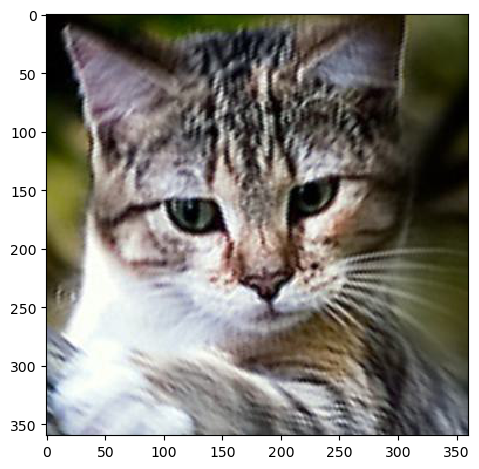

In [42]:

min_2_img = io.imread(preprocessed_images[ext_min_2])
min_2_img = create_u_byte_image_from_vector(min_2_img.flatten(), height, width, channels)
io.imshow(min_2_img)


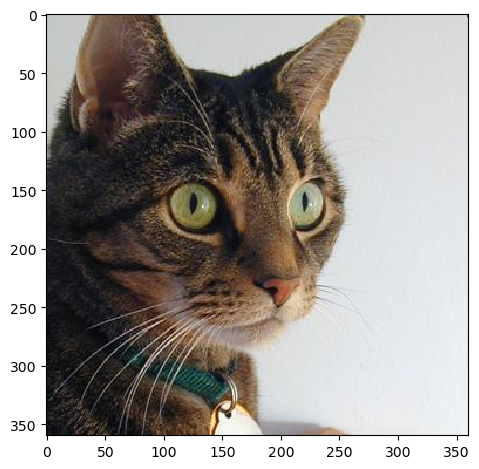

In [43]:

max_2_img = io.imread(preprocessed_images[ext_max_2])
max_2_img = create_u_byte_image_from_vector(max_2_img.flatten(), height, width, channels)
io.imshow(max_2_img)


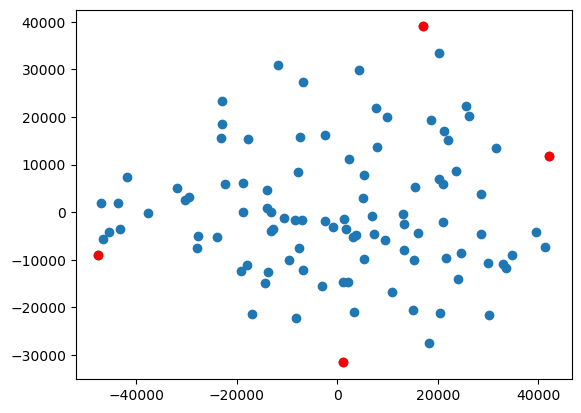

In [45]:
plt.scatter(pc_1, pc_2)
plt.scatter(pc_1[ext_min_1], pc_2[ext_min_1], c='r')
plt.scatter(pc_1[ext_min_2], pc_2[ext_min_2], c='r')
plt.scatter(pc_1[ext_max_2], pc_2[ext_max_2], c='r')
plt.scatter(pc_1[ext_max_1], pc_2[ext_max_1], c='r')

## Exercise 19

In [58]:
w = -20000
synth_cat = average_face + w * cats_pca.components_[0, :]


## Exercise 20

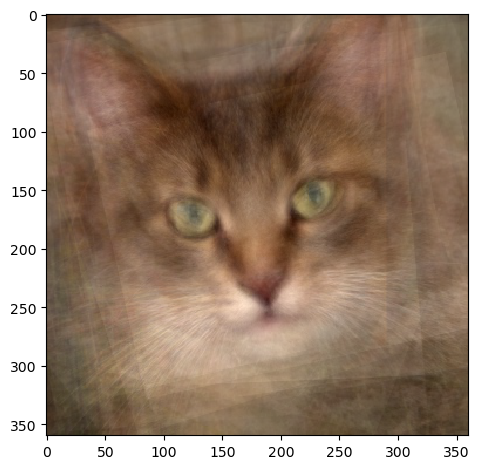

In [59]:
synth_cat_img = create_u_byte_image_from_vector(synth_cat, height, width, channels)
io.imshow(synth_cat_img)

## Exercise 21

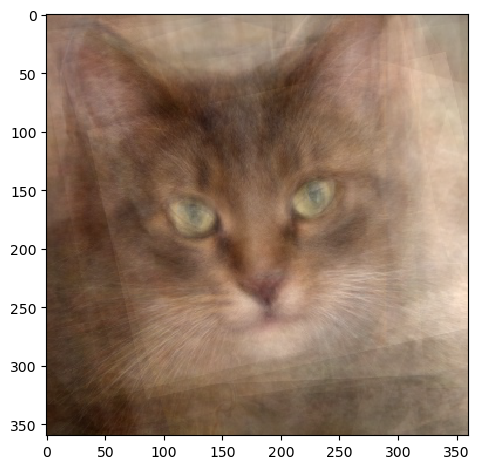

In [66]:
w = -20000
w2 = 10000
synth_cat_2d = average_face + w * cats_pca.components_[0, :] + w2 * cats_pca.components_[1, :]
synth_cat_2d_img = create_u_byte_image_from_vector(synth_cat_2d, height, width, channels)
io.imshow(synth_cat_2d_img)

## Exercise 22

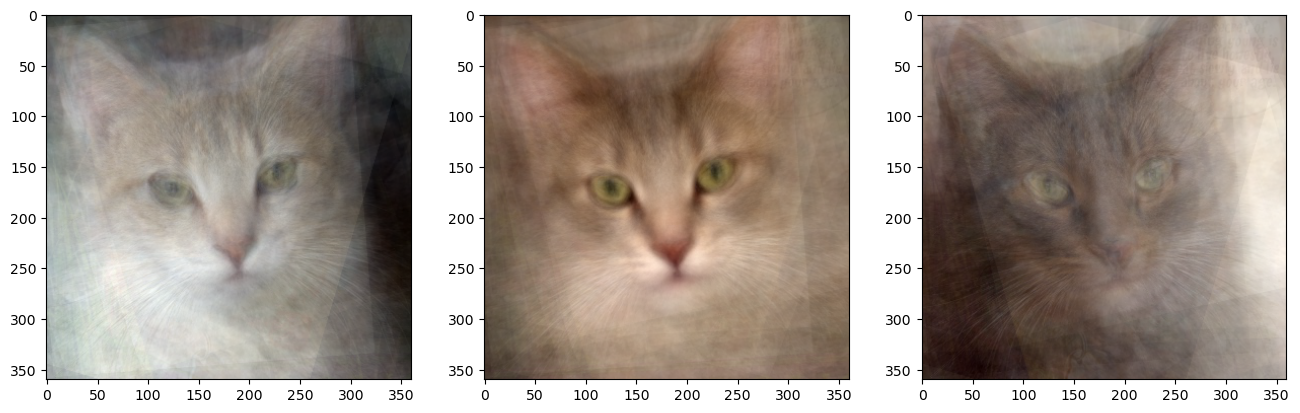

In [79]:
m = 1
synth_cat_plus = average_face + 3 * np.sqrt(cats_pca.explained_variance_[m]) * cats_pca.components_[m, :]
synth_cat_minus = average_face - 3 * np.sqrt(cats_pca.explained_variance_[m]) * cats_pca.components_[m, :]
synth_cat_plus_img = create_u_byte_image_from_vector(synth_cat_plus, height, width, channels)
synth_cat_minus_img = create_u_byte_image_from_vector(synth_cat_minus, height, width, channels)
fig, ax = plt.subplots(ncols=3, figsize=(16, 6))
ax[0].imshow(synth_cat_minus_img)
ax[1].imshow(average_face_img)
ax[2].imshow(synth_cat_plus_img)


## Exercise 23

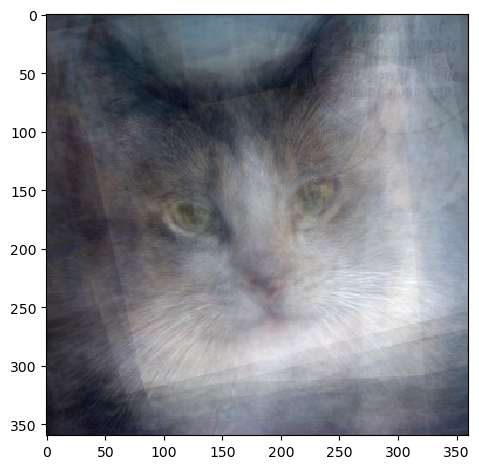

In [101]:
import random

n_components_to_use = 10
synth_cat = average_face
for idx in range(n_components_to_use):
	w = random.uniform(-1, 1) * 3 * np.sqrt(cats_pca.explained_variance_[idx])
	synth_cat = synth_cat + w * cats_pca.components_[idx, :]
	
synth_cat_img = create_u_byte_image_from_vector(synth_cat, height, width, channels)
io.imshow(synth_cat_img)

## Exercise 24

In [103]:
im_miss = io.imread("data/MissingCatProcessed.jpg")
im_miss_flat = im_miss.flatten()
im_miss_flat = im_miss_flat.reshape(1, -1)
pca_coords = cats_pca.transform(im_miss_flat)
pca_coords = pca_coords.flatten()
print(pca_coords)

[ -4673.13808771  -1631.6624327  -14065.28703897  -6458.20809113
   1187.86547134  -1309.87287761  -4381.81911675  -1772.85218074
    734.10039676   7605.63823095   2172.02607662   -519.15363969
   -545.40197007    948.35131696  -1651.67739038  -1736.50097419
  -4709.97073998  -2857.44770207  -1257.70721735   1950.54183174
   -103.99359306   1726.58349635  -1660.17482196  -1837.2526316
   2717.07377394    178.29891634  -1171.15865527  -2126.60079334
   -631.98938342  -2598.44157326  -2702.87827135   1513.41234752
    526.92186025   -887.66585877  -3235.21460066   -299.89404666
   1760.60431867   -333.95469583    483.49172731   -761.98252023
   -704.0484181    1479.04605635    790.06203885   1388.69188517
    166.48559103    768.49919846   1730.33991497  -1557.33310326
   -605.82686223    992.8038969 ]


## Exercise 25

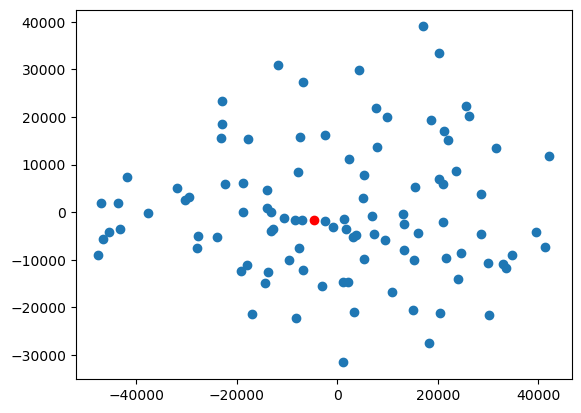

In [104]:
plt.scatter(pc_1, pc_2)
plt.scatter(pca_coords[0], pca_coords[1], c='r')

## Exercise 26

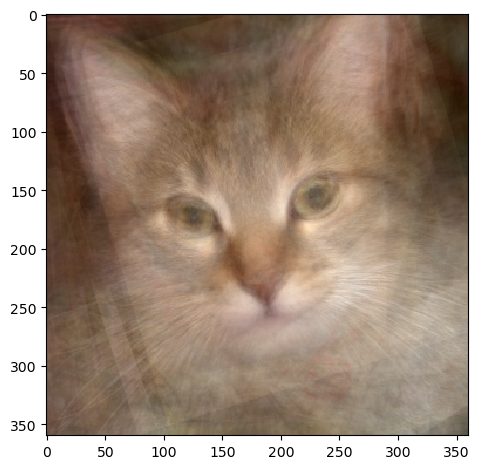

In [113]:
n_components_to_use = 20
synth_cat = average_face
for idx in range(n_components_to_use):
	synth_cat = synth_cat + pca_coords[idx] * cats_pca.components_[idx, :]

synth_cat_img = create_u_byte_image_from_vector(synth_cat, height, width, channels)
io.imshow(synth_cat_img)

## Exercise 27

79
32


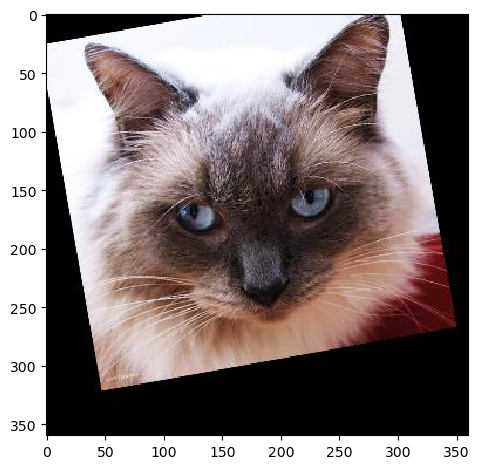

In [121]:
comp_sub = components - pca_coords
pca_distances = np.linalg.norm(comp_sub, axis=1)
print(pca_distances.argmax())
print(pca_distances.argmin())
furthest_img = create_u_byte_image_from_vector(data_matrix[79,:], height, width, channels)
io.imshow(furthest_img)

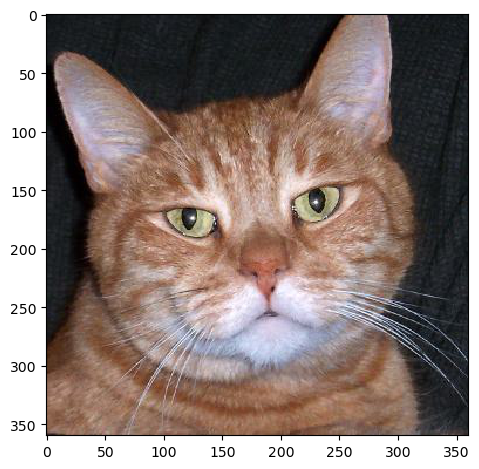

In [122]:
closest_img = create_u_byte_image_from_vector(data_matrix[32, :], height, width, channels)
io.imshow(closest_img)

## Exercise 28

In [127]:
# find the 5 images with lowest values
closest_5 = np.argsort(pca_distances)[:5]
print(closest_5)

[32 82 10 89  7]


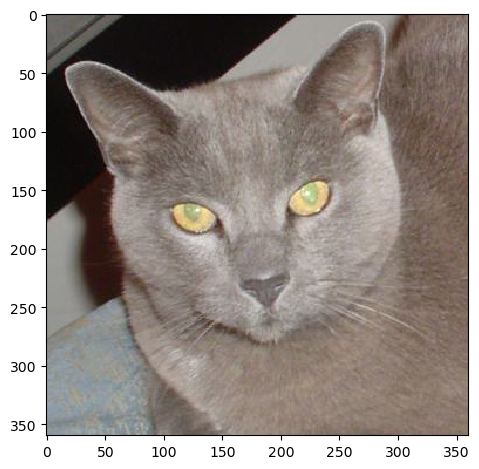

In [128]:
closest_img = create_u_byte_image_from_vector(data_matrix[82, :], height, width, channels)
io.imshow(closest_img)

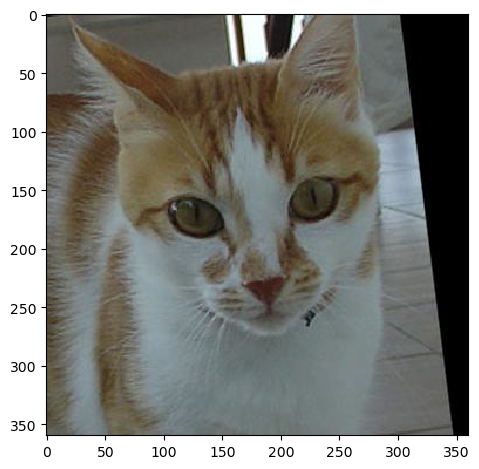

In [129]:
closest_img = create_u_byte_image_from_vector(data_matrix[10, :], height, width, channels)
io.imshow(closest_img)

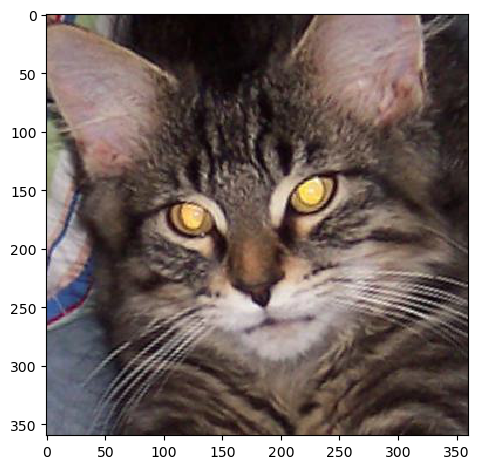

In [130]:
closest_img = create_u_byte_image_from_vector(data_matrix[89, :], height, width, channels)
io.imshow(closest_img)

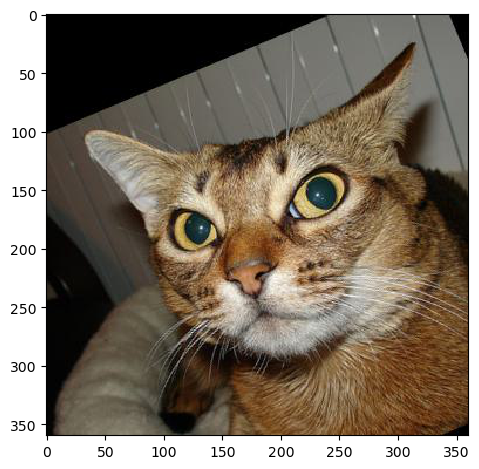

In [131]:
closest_img = create_u_byte_image_from_vector(data_matrix[7, :], height, width, channels)
io.imshow(closest_img)